In [25]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pynq import Xlnk, Overlay

加载IP比特流文件

In [26]:
resize_design = Overlay("resizer.bit")

然后创建DMA和IP对象

In [27]:
dma = resize_design.axi_dma_0
resizer = resize_design.resize_accel_1

创建一个图形对象

In [28]:
image_path = "sahara.jpg"
original_image = Image.open(image_path)

展示准备缩放的图像

Image size: 2560x1600 pixels.


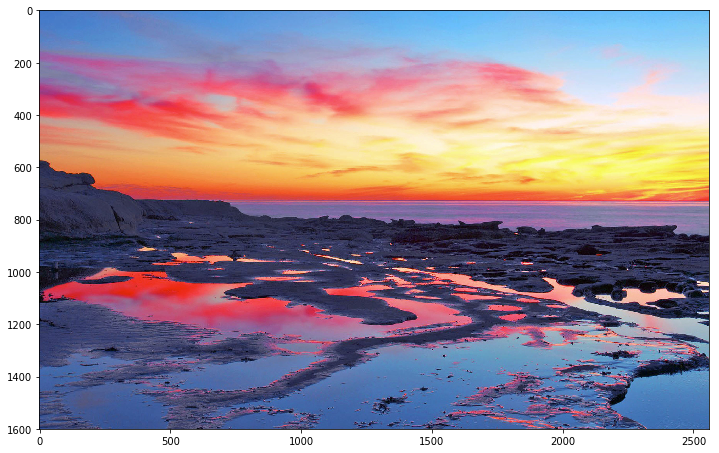

In [29]:
canvas = plt.gcf()
size = canvas.get_size_inches()
canvas.set_size_inches(size*2)

old_width, old_height = original_image.size
print("Image size: {}x{} pixels.".format(old_width, old_height))
_ = plt.imshow(original_image)

缩放 系数为2

In [30]:
resize_factor = 2
new_width = int(old_width/resize_factor)
new_height = int(old_height/resize_factor)

In [31]:
xlnk = Xlnk()
in_buffer = xlnk.cma_array(shape=(old_height, old_width, 3), 
                           dtype=np.uint8, cacheable=1)
out_buffer = xlnk.cma_array(shape=(new_height, new_width, 3), 
                            dtype=np.uint8, cacheable=1)

In [32]:
in_buffer[:] = np.array(original_image)

In [33]:
def run_kernel():
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)    
    resizer.write(0x00,0x81) # start
    dma.sendchannel.wait()
    dma.recvchannel.wait()

In [34]:
resizer.write(0x10, old_height)
resizer.write(0x18, old_width)
resizer.write(0x20, new_height)
resizer.write(0x28, new_width)

进行缩放操作

In [35]:
run_kernel()
resized_image = Image.fromarray(out_buffer)

展示缩放的图像

Image size: 1280x800 pixels.


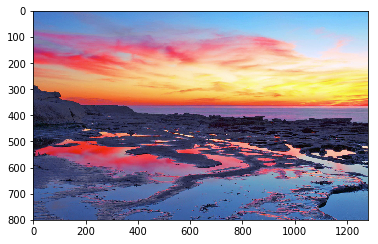

In [36]:
print("Image size: {}x{} pixels.".format(new_width, new_height))
_ = plt.imshow(resized_image)

我们可以对pl操作中的resize进行计时

In [37]:
%%timeit
run_kernel()
resized_image = Image.fromarray(out_buffer)

10 loops, best of 3: 91.8 ms per loop


最后重置所有连续的内存缓冲区

In [38]:
xlnk.xlnk_reset()